### Plots for paper

This notebook is used to generate all plots used in the paper, however not all plots generated in this notebook i used in the paper.

In [41]:
import pickle

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

sns.set_style('white')

import notebook_utils

In [2]:
links = gpd.read_file('../data_input/links.geojson').drop('id', axis = 1)
links_current = links[lambda x: (x['ValidFromDate'] <= '2019-01-01') & ('2019-01-01' < x['ValidToDate'])].set_index('LinkRef').drop(['ValidFromDate', 'ValidToDate'], axis = 1)

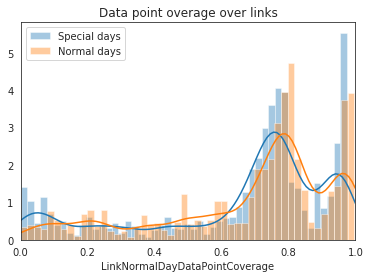

In [21]:
matrix_coverage = pd.read_csv('../data_input/matrix_coverage.csv', sep = ';', parse_dates=True, decimal=',')
fig, ax = plt.subplots(figsize = (6, 4))
ax.set_xlim(0, 1)
sns.distplot(matrix_coverage[matrix_coverage['LinkSpecialDayDataPointCoverage'] > 0]['LinkSpecialDayDataPointCoverage'], bins = 50, label = 'Special days')
sns.distplot(matrix_coverage[matrix_coverage['LinkNormalDayDataPointCoverage'] > 0]['LinkNormalDayDataPointCoverage'], bins = 50, label = 'Normal days')
ax.set_title('Data point overage over links')
ax.legend()

In [5]:
daytype_components = pd.read_csv('../output/reference-link-embeddings.csv', index_col=0)

In [12]:
with open('../output/matrix_imputed.pickle', 'rb') as f:
    matrix_imputed_pelt = pickle.load(f)

In [16]:
change_point_stats = pd.DataFrame([{k: x[k] for k in x.keys() if k not in ['imputed', 'change_points']} for x in matrix_imputed_pelt.values()]).set_index('link_ref')

In [33]:
change_point_stats['change_point_count'].value_counts().sort_index()

1     78
2    418
3    384
4    277
5    186
6     79
7     41
8     17
9      6
Name: change_point_count, dtype: int64

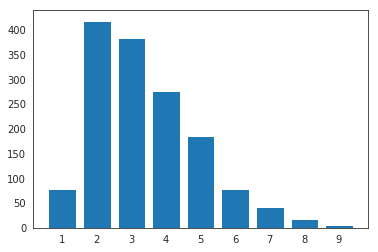

In [48]:
fig, ax = plt.subplots(figsize = (6, 4))
hist=change_point_stats['change_point_count'].value_counts().sort_index()
ax.set_xticks(np.arange(hist.max() + 1))
ax.bar(hist.index, hist.values)
fig.savefig('../plots/change_point_hist.pdf', bbox_inches = 'tight')

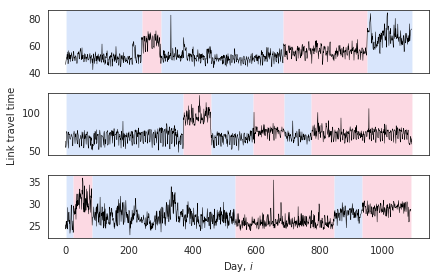

In [97]:
fig, ax = plt.subplots(figsize = (6, 4), nrows = 3, sharex=True)
fig.tight_layout()

from ruptures.utils import pairwise
from itertools import cycle

COLOR_CYCLE = ["#4286f4", "#f44174"]
beta = 0.9
change_point_stats_sel = change_point_stats[lambda x: (x['coverage'] > beta) & (x['change_point_count'] > 4)].sample(3, random_state = 10)

for i, (link_ref, row) in enumerate(change_point_stats_sel.iterrows()):
    color_cycle = cycle(COLOR_CYCLE)
    ax[i].plot(matrix_imputed_pelt[link_ref]['imputed'].values, color = 'k', linewidth = .5, linestyle = '-')
    #ax[i].set_title(link_ref)
    #rpt.display(link_travel_time_matrix_imputed_ls[i].values, change_points_ls[i], ax = ax)
    # color each (true) regime
    bkps = [0] + sorted(matrix_imputed_pelt[link_ref]['change_points'])

    for (start, end), col in zip(pairwise(bkps), color_cycle):
        ax[i].axvspan(max(0, start - 0.5), end - 0.5, facecolor=col, alpha=.2)

ax[-1].set_xlabel(r'Day, $i$')
fig.text(-0.01, 0.55, 'Link travel time', va='center', rotation='vertical')
fig.tight_layout()
fig.savefig('../plots/non-stationary-examples.pdf', bbox_inches = 'tight')

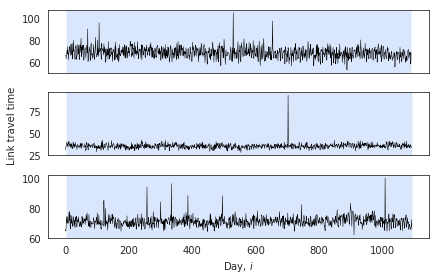

In [96]:
fig, ax = plt.subplots(figsize = (6, 4), nrows = 3, sharex=True)
fig.tight_layout()

from ruptures.utils import pairwise
from itertools import cycle

COLOR_CYCLE = ["#4286f4", "#f44174"]
beta = 0.9
change_point_stats_sel = change_point_stats[lambda x: (x['coverage'] > beta) & (x['change_point_count'] == 1)].sample(3, random_state = 10)

for i, (link_ref, row) in enumerate(change_point_stats_sel.iterrows()):
    color_cycle = cycle(COLOR_CYCLE)
    ax[i].plot(matrix_imputed_pelt[link_ref]['imputed'].values, color = 'k', linewidth = .5, linestyle = '-')
    #ax[i].set_title(link_ref)
    #rpt.display(link_travel_time_matrix_imputed_ls[i].values, change_points_ls[i], ax = ax)
    # color each (true) regime
    bkps = [0] + sorted(matrix_imputed_pelt[link_ref]['change_points'])

    for (start, end), col in zip(pairwise(bkps), color_cycle):
        ax[i].axvspan(max(0, start - 0.5), end - 0.5, facecolor=col, alpha=.2)

ax[-1].set_xlabel(r'Day, $i$')
fig.text(-0.01, 0.55, 'Link travel time', va='center', rotation='vertical')
fig.tight_layout()
fig.savefig('../plots/stationary-examples.pdf', bbox_inches = 'tight')

In [ ]:
import bokeh
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, ColorBar
from bokeh.models.mappers import LinearColorMapper
from bokeh.tile_providers import get_provider, Vendors

palette = bokeh.palettes.RdBu[9]
#palette = palette[::-1]
color_mapper = LinearColorMapper(palette = palette, low = 1, high = 9,  nan_color = palette[-1])
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
border_line_color='black',location = (0,0), orientation ='horizontal')
geosource = GeoJSONDataSource(geojson = links_current.to_crs({'init': 'epsg:3857'}).reset_index().to_json())
p = figure(title = 'Link Candidates', plot_height = 600 , plot_width = 1000, toolbar_sticky=False,
           tooltips=[
               ("CellRef", "@LinkRef"),
               ("Change Points", "@change_points")
           ],
           x_axis_type="mercator", y_axis_type="mercator")
#Makes it so there are no gird lines
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
p.add_tile(get_provider(Vendors.CARTODBPOSITRON))
p.multi_line('xs','ys', source = geosource, line_color = {'field': 'change_points', 'transform' : color_mapper}, line_width = 2, line_alpha = .5)
output_notebook()
show(p)